In [1]:
import numpy as np
import pandas as pd

train = pd.read_csv('../data/train.csv')

train=train[train.GrLivArea<4000]
train=train[train.LotArea<100000]
train.drop(['HouseStyle','BldgType','GarageCars','Utilities'], axis=1, inplace=True)

In [2]:
fix1=train[train.Exterior2nd=='Brk Cmn'].index.tolist()
train.loc[fix1,'Exterior2nd']='BrkComm'

fix2=train[train.Exterior2nd=='Wd Shng'].index.tolist()
train.loc[fix2,'Exterior2nd']='WdShing'

fix3=train[train.Exterior2nd=='CmentBd'].index.tolist()
train.loc[fix3,'Exterior2nd']='CemntBd'

train['Diff_in_Ext']=train.apply(lambda x: 1 if x.Exterior2nd!=x.Exterior1st else 0, axis=1)

map_overall_to_cat={10:'High',9:'High',8:'High',7:'Average',6:'Average',5:'Average',4:'Average',
                    3:'Low',2:'Low',1:'Low'}

train.OverallCond=train.OverallCond.map(map_overall_to_cat)
train.OverallQual=train.OverallQual.map(map_overall_to_cat)

cat_c=[]
for c in train.columns.tolist():
    if train[c].dtypes=='object':
        cat_c.append(c)
cat_c.remove('MSZoning')
#cat_c.remove('Alley')
#cat_c.remove('MiscFeature')

In [3]:
def turn_garage_data_into_dummy(df):
    for i in df.Neighborhood.unique().tolist():
        name="Garage_in_"+str(i)
        df[name]=np.where((df.Neighborhood==i)&(df.GarageArea!=0),1,0)
        
turn_garage_data_into_dummy(train)

In [4]:
def make_dummies_conditional_on_len(train,c):
    df=train.groupby(c).Id.count()
    for i in df.index.tolist():
        if df.loc[i]>=50:
            name=str(c)+'_'+str(i)
            train[name]=np.where(train[c]==i,1,0)
    train.drop(c,axis=1, inplace=True)

for c in cat_c:
    make_dummies_conditional_on_len(train,c)

train.drop(['SaleType_New', 'CentralAir_Y','LandSlope_Gtl' ,'BsmtFinType2_Unf',
            'Foundation_PConc','RoofStyle_Gable', 'PavedDrive_Y','Electrical_SBrkr'], axis=1,inplace=True)


train.shape

(1452, 158)

In [5]:
LotFrontage_to_fix=train[train.LotFrontage.isnull()].index.tolist()
train.loc[LotFrontage_to_fix,'LotFrontage']=train.LotFrontage.mean()

MasVnrArea_to_fix=train[train.MasVnrArea.isnull()].index.tolist()
train.loc[MasVnrArea_to_fix,'MasVnrArea']=0

GarageYrBlt_to_fix=train[train.GarageYrBlt.isnull()].index.tolist()
train.loc[GarageYrBlt_to_fix,'GarageYrBlt']=train.GarageYrBlt.mean().round(0)

def turn_MS_data_into_cat(df):
    for i in df.MSSubClass.unique().tolist():
        for j in df.MSZoning.unique().tolist():
            if df[(df.MSSubClass==i)&(df.MSZoning==j)].Id.count()>=20:
                name=str(i)+'_'+str(j)
                df[name]=np.where((df.MSSubClass==i)&(df.MSZoning==j),1,0)
    df.drop(['MSSubClass','MSZoning'], axis=1, inplace=True)
turn_MS_data_into_cat(train)

#train.drop('YearBuilt', axis=1, inplace=True)

train.loc[train[train.YearRemodAdd>train.YrSold].index,'YearRemodAdd']=2007

train['Avg_room_size']=train.GrLivArea/train.TotRmsAbvGrd

train=pd.concat([train,pd.get_dummies(train.BedroomAbvGr, prefix="br")], axis=1)
train.drop('br_8', axis=1, inplace=True)

train.shape

(1452, 180)

In [6]:
train['SaleDate']=train.apply(lambda x: str(int(x.YrSold))+'-'+str(int(x.MoSold))+'-'+str(1), axis=1)
train['SaleDate']=pd.to_datetime(train['SaleDate'])

n_transaction=train.groupby('SaleDate').size()
train['n_transaction']=n_transaction.loc[train.SaleDate].values
train['Log_sale_price']=np.log10(train.SalePrice)
train.drop('SalePrice', axis=1, inplace=True)


In [7]:
usa_sale_prices=pd.read_csv("../data/USA-House_prices_monthly_excat_dates.csv")
usa_sale_prices.DATE=pd.to_datetime(usa_sale_prices.DATE, infer_datetime_format=True)
usa_sale_prices.DATE=usa_sale_prices.DATE.dt.strftime('%Y-%d-%m')
usa_sale_prices.DATE=pd.to_datetime(usa_sale_prices.DATE, infer_datetime_format=True)
usa_sale_prices.set_index('DATE', inplace=True)
train['Price_index']=usa_sale_prices.loc[train.SaleDate].values

In [8]:
Ames_sale_prices_Q=pd.read_csv("../data/Ames_House_prices.csv")
Ames_sale_prices_Q.DATE=pd.to_datetime(Ames_sale_prices_Q.DATE)
Ames_sale_prices_Q.set_index('DATE', inplace=True)

timerange=[]
for i in range(2006,2011):
    for j in range(1,13):
        timerange.append(str(i)+'-'+str(j)+'-'+str(1))
timerange=pd.to_datetime(timerange)

Ames_sale_prices_M=pd.DataFrame(data=np.nan, index=np.arange(55), columns=['Date','Value'])
Ames_sale_prices_M.Date=timerange[:-5]
Ames_sale_prices_M.set_index('Date', inplace=True)

Ames_sale_prices_M.Value=Ames_sale_prices_Q.loc[Ames_sale_prices_M.index].values

def fancy_forward_fill(Ames_sale_prices_M):
    for i in range(0,52,3):
        v0=Ames_sale_prices_M.iloc[i].values
        v1=Ames_sale_prices_M.iloc[i+3].values
        j=(v1-v0)/3
        Ames_sale_prices_M.iloc[i+1]=v0+j
        Ames_sale_prices_M.iloc[i+2]=v0+(2*j)
fancy_forward_fill(Ames_sale_prices_M)

train['Price_index_Ames']=Ames_sale_prices_M.loc[train.SaleDate].values

C:\Users\liort\Anaconda3\envs\py4dp\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app


In [9]:
ue=pd.read_csv("../data/Unemployment in Ames.csv")
ue.DATE=pd.to_datetime(ue.DATE)
ue.set_index('DATE', inplace=True)
train['UnEmployment']=ue.loc[train.SaleDate].values

In [10]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


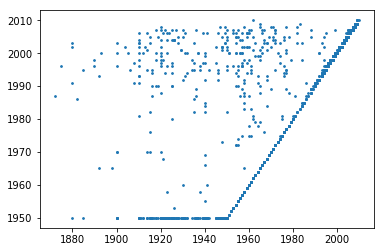

In [11]:
plt.scatter(train.YearBuilt, train.YearRemodAdd, s=3)

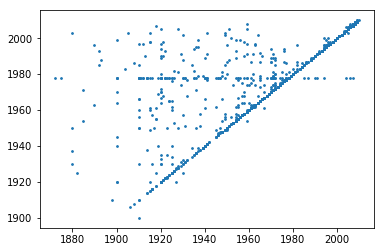

In [12]:
plt.scatter(train.YearBuilt, train.GarageYrBlt, s=3)

In [17]:
train[train.GarageYrBlt<train.YearBuilt].loc[:,['GarageYrBlt','YearBuilt']]

,GarageYrBlt,YearBuilt
29,1920.0,1927
89,1978.0,1994
93,1900.0,1910
148,1978.0,2004
324,1961.0,1967
582,1978.0,1990
600,2003.0,2005
613,1978.0,2007
736,1949.0,1950
738,1978.0,1987


In [18]:
train.YearRemodAdd=train.apply(lambda x: x.YearBuilt if ((x.YearRemodAdd==1950)&(x.YearBuilt<1950)) else x.YearRemodAdd, axis=1)
train.GarageYrBlt=train.apply(lambda x: x.YearBuilt if ((x.YearBuilt>x.GarageYrBlt)) else x.GarageYrBlt, axis=1)

(array([0.12182741, 0.10659898, 0.11675127, 0.05583756, 0.05076142,
        0.04060914, 0.16751269, 0.16243655, 0.08121827, 0.0964467 ]),
 array([1970., 1971., 1972., 1973., 1974., 1975., 1976., 1977., 1978.,
        1979., 1980.]),
 <a list of 10 Patch objects>)

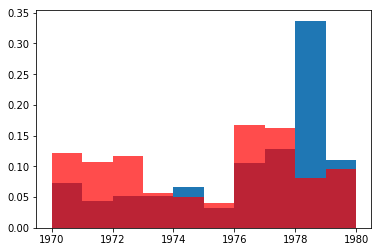

In [30]:
plt.hist(train.GarageYrBlt, range=[1970,1980],bins=10,density=True)
plt.hist(train.YearBuilt, range=[1970,1980],bins=10,density=True, color='r',alpha=0.7)

In [31]:
train.GarageYrBlt.value_counts()

1978.0    92
2005.0    66
2006.0    60
2004.0    54
2007.0    49
2003.0    49
1977.0    35
1998.0    31
1999.0    30
1976.0    29
2008.0    28
2000.0    27
2002.0    26
1968.0    26
1950.0    25
1993.0    22
1966.0    21
2009.0    21
2001.0    20
1970.0    20
1957.0    20
1958.0    20
1962.0    20
1965.0    19
1960.0    19
1996.0    19
1997.0    19
1994.0    18
1954.0    18
1959.0    18
          ..
1926.0     6
1936.0     5
1916.0     5
1931.0     4
1935.0     4
1945.0     4
1922.0     4
1910.0     4
1982.0     4
1923.0     4
1928.0     4
1946.0     4
1952.0     3
1938.0     3
1924.0     3
1932.0     3
2010.0     3
1921.0     3
1947.0     2
1927.0     2
1918.0     2
1929.0     2
1914.0     2
1915.0     2
1934.0     2
1937.0     2
1942.0     2
1906.0     1
1908.0     1
1933.0     1
Name: GarageYrBlt, Length: 96, dtype: int64

In [33]:
train['Garage_buit_in_1978_maybe_a_mistake']=train.apply(lambda x: 1 if x.GarageYrBlt==1978 else 0,axis=1)

In [34]:
train.shape

(1452, 186)

In [35]:
train.to_csv('../data/train_preperd01.csv')

## test set

In [38]:
test= pd.read_csv('../data/test.csv')

fix_year=test.loc[test.GarageYrBlt>2010].GarageYrBlt.index.values.tolist()
test.loc[fix_year,'GarageYrBlt']=np.nan

fix4=test[test.Exterior2nd=='Brk Cmn'].index.tolist()
test.loc[fix4,'Exterior2nd']='BrkComm'

fix5=test[test.Exterior2nd=='Wd Shng'].index.tolist()
test.loc[fix5,'Exterior2nd']='WdShing'

fix6=test[test.Exterior2nd=='CmentBd'].index.tolist()
test.loc[fix6,'Exterior2nd']='CemntBd'

test.loc[test[test.YearRemodAdd>test.YrSold].index, 'YearRemodAdd']=2007 


test.OverallCond=test.OverallCond.map(map_overall_to_cat)
test.OverallQual=test.OverallQual.map(map_overall_to_cat)
test['Diff_in_Ext']=test.apply(lambda x: 1 if x.Exterior2nd!=x.Exterior1st else 0, axis=1)

for c in cat_c:
    test=pd.concat([test,pd.get_dummies(test[c], prefix=c)], axis=1)

turn_MS_data_into_cat(test)

test=pd.concat([test,pd.get_dummies(test.BedroomAbvGr, prefix="br")], axis=1)

test['SaleDate']=test.apply(lambda x: str(int(x.YrSold))+'-'+str(int(x.MoSold))+'-'+str(1), axis=1)
test['SaleDate']=pd.to_datetime(test['SaleDate'])
test['n_transaction']=n_transaction.loc[test.SaleDate].values

test['120_RM']=0
test['Avg_room_size']=test.GrLivArea/test.TotRmsAbvGrd


turn_garage_data_into_dummy(test)
test['UnEmployment']=ue.loc[test.SaleDate].values
test['Price_index_Ames']=Ames_sale_prices_M.loc[test.SaleDate].values

test.loc[test[test.GarageArea.isnull()==True].index.tolist(),'GarageArea']=0
test.loc[test[test.TotalBsmtSF.isnull()==True].index.tolist(),'TotalBsmtSF']=0
test.loc[test[test.BsmtFinSF1.isnull()==True].index.tolist(),'BsmtFinSF1']=0


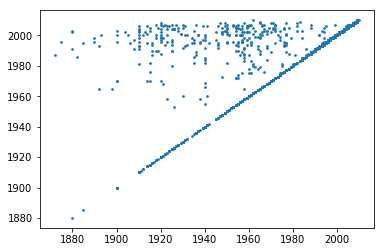

In [39]:
plt.scatter(train.YearBuilt, train.YearRemodAdd, s=3)

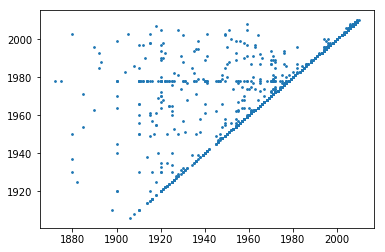

In [40]:
plt.scatter(train.YearBuilt, train.GarageYrBlt, s=3)

In [41]:
test.shape

(1459, 354)

In [42]:
test.to_csv('../data/test_preperd01.csv')